<a href="https://colab.research.google.com/github/ZackPashkin/AutoToloka/blob/main/AUTOTOLOKA_API_v060720.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#TODO
#remove lists
#fix dataframe saving
#set up get_preds on batch

# Install libs

In [ ]:
#@title
!git clone https://github.com/idealo/imagededup.git
%cd imagededup
!pip install "cython>=0.29"
!python setup.py install

# Results manager

In [ ]:
import os
from datetime import datetime

class Settings:
  def __init__(self):
    # self.status = input("Status of photos.Select SUBMITTED/REJECTED/ACCEPTED. Default SUBMITTED: ") or 'SUBMITTED'
    # self.name = input("Project short name. Select m_tarif/o_tarif. Default o_tarif: ") or "o_tarif" 
    # self.limit = input("Set limit number of photos to download. Default 10000: ") or "10000"
    self.status = "ACCEPTED"
    self.name  = "drawings_docs"
    self.limit = "100000"

    # self.path_to_save_photos = f'{os.path.abspath(os.getcwd())}/{self.status}_{self.name}_{datetime.now().strftime("%d-%m-%Y_%I-%M-%S_%p")}'
    
    self.path_to_save_photos = "/content/ACCEPTED_j_28-12-2020_07-42-15_AM"
    # self.TOLOKA_OAUTH_TOKEN = "SOMEFAKETOKENAgAAADJONIHONOJPNDWQYUfUoWUvLJHJPJ"
    self.TOLOKA_OAUTH_TOKEN = "tokenhere"
    self.URL_API = "https://toloka.yandex.ru/api/v1/"
    self.types = [".png",".jpg", ".JPEG", ".JPG", ".jpeg"]
    print('Set pool id: 13567188 multi, 13076408 one ')
    # if self.name == 'm_tarif':
    #   self.pool_id = '13567188'
    # elif self.name == 'o_tarif':     
    #   self.pool_id = '13076408'
    # else:
    #   self.pool_id = input()
    self.pool_id = "19662458"
    
settings = Settings() 
settings.path_to_save_photos
print(settings.status)
print(settings.name)
print(settings.limit)
print(settings.pool_id)

Set pool id: 13567188 multi, 13076408 one 
ACCEPTED
drawings_docs
100000
19662458


In [ ]:
settings.path_to_save_photos

'/content/ACCEPTED_j_28-12-2020_07-42-15_AM'

In [ ]:
import json
import http.client

class TolokaHandleResults:
  """Process filtered results.Send to Toloka."""
  def __init__(self):    
    self.api_host = "toloka.yandex.ru"

  def download_images(self):
    if not os.path.exists(settings.path_to_save_photos):
      os.makedirs(settings.path_to_save_photos)

    HEADERS = {
        "Authorization": "OAuth %s" % settings.TOLOKA_OAUTH_TOKEN,
        "Content-Type": "application/JSON",
    }

    # Get the list of pools in the current project.

    all_files = glob.glob(f"{settings.path_to_save_photos}\*.*")
    url_pools = (
            settings.URL_API + f"pools/{settings.pool_id}"
    )
    POOL_ID = requests.get(url_pools, headers=HEADERS).json()
    pool_id = POOL_ID['id']
    print(f"{pool_id}")
    
    # We get a list of all the answers from the pool that are waiting for verification
    url_assignments = (
            settings.URL_API + f"assignments/?status={settings.status}&limit={settings.limit}&pool_id=%s" % pool_id  # set amount limit
    )
    submitted_tasks = requests.get(url_assignments, headers=HEADERS).json()["items"]

    # DOWNLOAD SUBMITTED PHOTOS FROM TOLOKA
    for task in tqdm(submitted_tasks):
        try:
            url_file = (
                    settings.URL_API + "attachments/%s" % task['solutions'][0]['output_values']['image'] 
            )
        except:
            continue

        info_file = requests.get(url_file, headers=HEADERS).json()
        file_name = list(info_file['details'].values())
        file_date = info_file['created']
        file_name_jpg = info_file['name']
        file_name = f'{file_name[1]}_{file_name[0]}_{file_name_jpg}'
        print(file_name)

        if file_name not in all_files:
            # download file with get request
            file_download = requests.get(url_file + "/download", headers=HEADERS)  
            # open method to open a file on your system and write the contents
            with open(Path(settings.path_to_save_photos + r'/%s' % file_name), "wb") as file:
                file.write(file_download.content)
    
    print("Complete")

  def make_call(self,method, url, body=None):
    client = http.client.HTTPSConnection(self.api_host)
    headers = {"Authorization": "OAuth " + self.oauth_token,
          "Content-Type": "application/json"}
    client.request(method, "/api/v1" + url, body, headers)
    r = client.getresponse()
    print(r.read())
    client.close()

  def offline_accept(self,assignment_id,status,public_comment):
    url = "/assignments/" + assignment_id
    print(url)
    body = """
    {
                "status": """ + "\"" + status + "\"" + """,
                "public_comment": """ + "\"" + public_comment + "\"" + """
            }
    """
    print(body)
    self.make_call("PATCH", url, body.encode("utf-8"))

  def send_rejected(self,some_list,public_comment = "Благодарим за фото! ",status = "ACCEPTED"):
    # def send_rejected(self,some_list,public_comment = "Не соответствует требованиям инструкции",status = "REJECTED"):
    # status = "REJECTED"
    # public_comment = "Не соответствует требованиям инструкции."
    for assignment_id in some_list:
        self.offline_accept(assignment_id,status,public_comment)

  # def send_accepted(self, good_list):
  #   status = "ACCEPTED"
  #   public_comment = "Благодарим за фото!"
  #   for assignment_id in df['accepted']:
  #       offline_accept(assignment_id,status,public_comment)




In [ ]:
import pandas as pd
import requests
from pathlib import Path
import glob
from tqdm.notebook import tqdm
import os
import random
# from imagededup.methods import CNN
from fastai import *
from fastai.vision import *
import warnings
warnings.filterwarnings("ignore")
defaults.device = torch.device('cuda')


class TolokaFilterResults(Settings, TolokaHandleResults):  
  """Process photos checks by NN"""

  def __init__(self):
    super().__init__()
    self.IMAGE_DIR_ALL = settings.path_to_save_photos
    # self.learn = load_learner('/content/').to_fp16() 

  def download_img_from_here(self):
    self.download_images()

  def check_duplicates(self):
    

    df_duplicates = pd.DataFrame({'duplicates':[]})  
    cnn_encoder = CNN()
    duplicates_list_cnn = cnn_encoder.find_duplicates_to_remove(image_dir=self.IMAGE_DIR_ALL)
    df_duplicates = df_duplicates.append({'duplicates': duplicates_list_cnn},ignore_index=True)
    df_duplicates.to_csv('duplicates.csv', index=False)
    r_list = duplicates_list_cnn
    print(len(r_list))
    print(r_list)

    # self.send_rejected(self.prepare_to_send(r_list))
  
  def send_from_here(self,r_list):

    self.send_rejected(self.prepare_to_send(r_list))

  def prepare_to_send(self,r_list):
    DUPLICATES_FLAT_CLEAR = r_list
    #split the name for sending id / PREPARE FOR SENDING TO TOLOKA
    DUPLICATES_LIST = []
    for i in DUPLICATES_FLAT_CLEAR:
      split = (i.split('_'))
      DUPLICATES_LIST.append(split[0])
    print(f"Duplicates prepared.Ready for sending {len(DUPLICATES_LIST)} REJECTED")
    print(DUPLICATES_LIST)
    return DUPLICATES_LIST
      
  def load_model(self, what_task=input("Choose the task you want a model for:(presense/multi_or_one). Default: presense")):
    # Download model
    if what_task == 'presense':
      #wget here
      !gsutil -m cp -r gs://toloka-main/models/export_presense_classif003.pkl  /content/export.pkl 
    elif what_task == 'multi_or_one':
      !gsutil -m cp -r gs://toloka-main/models/export_multione003.pkl /content/export.pkl
    else:
      raise ValueError('Check what_task is appropriate(presense/multi_or_one)')

    self.learn = load_learner('/content/').to_fp16() 
    
  def show_and_predict_image(self):
    img= random.choice(os.listdir(self.IMAGE_DIR_ALL))
    img = open_image(f'{self.IMAGE_DIR_ALL}/{img}')
    img.show()
    listi = []
    learn = self.learn
    pred_class,pred_idx,outputs = learn.predict(img)
    print(pred_class)
    print(pred_class.data.tolist())

  def skip_images(self,r_list,GARBAGE_LIST=None):
    if GARBAGE_LIST != None:
      SKIP_LIST = r_list + GARBAGE_LIST
    else:
      SKIP_LIST = r_list
    return SKIP_LIST

  def check(self,r_list):
    
    self.learn = load_learner('/content/').to_fp16() 
    DATA = self.IMAGE_DIR_ALL

    multi_tarif_list = []
    tarif_list = []

    df_tarif_list = pd.DataFrame({'o_tarif': []})
    df_m_tarif_list = pd.DataFrame({'m_tarif': []})

    SKIP_LIST = self.skip_images(r_list)

    # learn = load_learner('/content', 'export.pkl', test = SegmentationItemList.from_folder(DATA), tfm_y=False).to_fp16()
    # preds = learn.get_preds(ds_type=DatasetType.Test)

    for img in tqdm(os.listdir(DATA)):
      try:
        if img not in SKIP_LIST:  
          img_pred = open_image(os.path.join(DATA,img))
          pred_class,pred_idx,outputs = self.learn.predict(img_pred)
          preds = pred_class.data.tolist()
          if preds == 1:  
            tarif_list.append(img) 
          else:
            multi_tarif_list.append(img)
         
      except IOError:
          continue
    
    df_tarif_list = df_tarif_list.append({'o_tarif': tarif_list}, ignore_index=True,)    
    df_m_tarif_list = df_m_tarif_list.append({'m_tarif': multi_tarif_list}, ignore_index=True)
      
    print(tarif_list)
    print(multi_tarif_list)
    df_tarif_list.to_csv("o_tarif.csv", index=False)
    df_m_tarif_list.to_csv("m_tarif.csv", index=False)


  def look_at_results(self):
    for img in tarif_list[:10]:
      img = open_image(f'{self.IMAGE_DIR_ALL}/{img}')
      img.show(figsize=(2,2))

  def remove_rejected_from_dir(self,r_list):
    "Delete rejected images from directory"
    for i in r_list:
      try:
          os.remove(f'{self.IMAGE_DIR_ALL}/{i}')
      except FileNotFoundError:
          print("Wrong file or file path")

    dir_len = len([name for name in os.listdir(self.IMAGE_DIR_ALL)])
    print(dir_len)
    print('-------------------------------')
    print('it was',f'{len(r_list) + dir_len}', 'in the beginning')

  def show_img_banch(self,r_list):
    "Show bunch of images"
    for img in r_list[30:59]:
      img = open_image(f'{self.IMAGE_DIR_ALL}/{img}')
      img.show(figsize=(2,2))

Choose the task you want a model for:(presense/multi_or_one). Default: presense


In [ ]:
results = TolokaFilterResults()

Set pool id: 13567188 multi, 13076408 one 


In [ ]:
# 19662458
results.download_img_from_here()

19662458



Complete


In [ ]:
# from imagededup.methods import CNN
results.check_duplicates()

17227776/17225924 [==============================] - 0s 0us/step


2020-06-29 07:49:33,755: INFO Initialized: MobileNet pretrained on ImageNet dataset sliced at last conv layer and added GlobalAveragePooling
2020-06-29 07:49:33,756: INFO Start: Image encoding generation


Instructions for updating:
Please use Model.predict, which supports generators.
57/57 [==============================] - 988s 17s/step


2020-06-29 08:06:46,321: INFO End: Image encoding generation
2020-06-29 08:06:46,333: INFO Start: Calculating cosine similarities...
2020-06-29 08:06:46,636: INFO End: Calculating cosine similarities.


511
['0000cf04d4--5ec560825778794eb1d82ff2_75edc85d01e2b2a7666f35318d12db47_JPEG_20200520_195325.jpg', '0000cf04d4--5ef12c04c1df5c3a50f9ee18_01c0338a3ffb818a726bea6d6ebe691a_JPEG_20200623_010912.jpg', '0000cf04d4--5ec7e6bbc624a660c73a1517_4654591b3b2df70fb131d150c7436457_JPEG_20200522_195044.jpg', '0000cf04d4--5ee8f24272ac6c1ac5f1ba44_0d0114c0e40d33cb78c3cdc82e7078f6_ED1A3AF1-0846-47F5-8CE2-CE3F9AE85E60.jpg', '0000cf04d4--5ec9fe128d7c7975c5934c6d_52339f0d0701cc440a3edc9b947ec80e_JPEG_20200524_105525.jpg', '0000cf04d4--5ee9af9aea9b1321c208cada_62480927d4e8d3ba111898283b704392_JPEG_20200617_085228.jpg', '0000cf04d4--5ec4c2239e13700cfaa538e5_644b861f3ff85c2983b12a7683d362d4_JPEG_20200520_083633.jpg', '0000cf04d4--5ee9f5f171ac456ae0ce79ef_4c268994cf922975af4bfc20df36e963_0BAC4584-6BC5-41CB-BDDB-2F882C67699F.jpg', '0000cf04d4--5ee8b81c6f6bd626c0356db3_0d0114c0e40d33cb78c3cdc82e7078f6_171D4BE0-F3A0-40CA-8C7D-30533C1FC7F9.jpg', '0000cf04d4--5eef64cf3367bf1a0afbbdd1_7dd66926ae82e6186a42ca9b50b

# Trash

In [ ]:
!gcloud init

In [ ]:
# !gcloud init
# !zip -r /content/SUBMITTED_m_tarif_26-06-2020_06-29-30_AM.zip /content/SUBMITTED_m_tarif_26-06-2020_06-29-30_AM
# upload
# !gsutil -m cp -r /content/SUBMITTED_m_tarif_26-06-2020_06-29-30_AM gs://toloka-main/m_tarif/SUBMITTED_m_tarif_26-06-2020_06-29-30_AM.zip
!gsutil -m cp -r gs://toloka-main/m_tarif/to_accept_m_tarif_SUBMITTED_m_tarif_26-06-2020_06-29-30_AM.zip /content

Copying gs://toloka-main/m_tarif/to_accept_m_tarif_SUBMITTED_m_tarif_26-06-2020_06-29-30_AM.zip...
\ [1/1 files][  1.6 GiB/  1.6 GiB] 100% Done  57.6 MiB/s ETA 00:00:00           
Operation completed over 1 objects/1.6 GiB.                                      


In [ ]:
!gsutil -m cp -r /content/SUBMITTED_m_tarif_26-06-2020_06-29-30_AM.zip gs://toloka-main/m_tarif/SUBMITTED_m_tarif_26-06-2020_06-29-30_AM.zip

Copying file:///content/SUBMITTED_m_tarif_26-06-2020_06-29-30_AM.zip [Content-Type=application/zip]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

| [1/1 files][  2.7 GiB/  2.7 GiB] 100% Done  82.8 MiB/s ETA 00:00:00           
Operation completed over 1 objects/2.7 GiB.                                      


In [ ]:
!unzip /content/to_accept_m_tarif_SUBMITTED_m_tarif_26-06-2020_06-29-30_AM.zip  -d /content

In [ ]:
len([i for i in os.listdir('/content/to_accept_m_tarif_SUBMITTED_m_tarif_26-06-2020_06-29-30_AM')])

547

In [ ]:
good_list = [i for i in os.listdir('/content/to_accept_m_tarif_SUBMITTED_m_tarif_26-06-2020_06-29-30_AM')]

In [ ]:
good_list

In [ ]:
#send accept
results.send_from_here(good_list)

Duplicates prepared.Ready for sending 547 REJECTED
['0000cf04d4--5eed767beb4c890eb663d8bf', '0000cf04d4--5eea42842d02221caf3efd5a', '0000cf04d4--5eea131eea9b1321c20c8c93', '0000cf04d4--5eef811d65018444d53b9725', '0000cf04d4--5eeb3941e64ea01adddfb416', '0000cf04d4--5ee73d80edadd72d0a999c32', '0000cf04d4--5eee33fe0156cf2f3821d50f', '0000cf04d4--5ef0c0a4a661044e00fcb069', '0000cf04d4--5eed07d67cef600cea8c9742', '0000cf04d4--5eea048b72ac6c1ac5f872b5', '0000cf04d4--5eee38a265018444d535a2e7', '0000cf04d4--5ee9142ac71ebe5601633583', '0000cf04d4--5ee844efedadd72d0aa00c33', '0000cf04d4--5eeae9cf4f163f40a3d74d97', '0000cf04d4--5eeff4e28b044a4934a7eb1a', '0000cf04d4--5eec196bbcb8f72c98689c3d', '0000cf04d4--5ee8a8027aca3636018fe09c', '0000cf04d4--5eebaaf16fe7e00411387bbf', '0000cf04d4--5ee745c251eb8e792779a3a4', '0000cf04d4--5eea3628896b2609e17c474e', '0000cf04d4--5eedf0587cef600cea90ebba', '0000cf04d4--5eec882c90097f31b79886bd', '0000cf04d4--5ee89c1271ac456ae0c4e549', '0000cf04d4--5eea141e7e1dd26

In [ ]:
garbage_list = []
with open("/content/multi_garbage.txt", "r") as f:
  garbage_list = f.read()

len([i for i in garbage_list])
garbage_list=garbage_list.replace("[","")
garbage_list=garbage_list.replace("]","")
garbage_list=garbage_list.replace("\n","")
garbage_list=garbage_list.replace("'","")
garbage_list = list(garbage_list.split(", ")) 
len(garbage_list)
garbage_list
   


In [ ]:
!zip -r /content/REJECTED_m_tarif_27-06-2020_06-42-00_AM.zip /content/REJECTED_m_tarif_27-06-2020_06-42-00_AM

In [ ]:
!gsutil -m cp -r /content/REJECTED_m_tarif_27-06-2020_06-42-00_AM gs://toloka-main/m_tarif/ALL/REJECTED_m_tarif_27-06-2020_06-42-00_AM

In [ ]:
import time
time.sleep(100000000)

In [ ]:
results = TolokaFilterResults()

Status of photos.Select SUBMITTED/REJECTED/ACCEPTED. Default SUBMITTED: 
Project short name. Select m_tarif/o_tarif. Default o_tarif: 
Set limit number of photos to download. Default 10000: 
Set pool id: 13567188 multi, 13076408 one 


In [ ]:
len(garbage_list)

740

In [ ]:
checks.show_img_banch(r_list=garbage_list)

In [ ]:
results.remove_rejected_from_dir(r_list=garbage_list)

2772
-------------------------------
it was 3512 in the beginning


In [ ]:
results.load_model(what_task='multi_or_one')

Copying gs://toloka-main/models/export_multione003.pkl...
| [1/1 files][ 41.8 MiB/ 41.8 MiB] 100% Done                                    
Operation completed over 1 objects/41.8 MiB.                                     


one
1


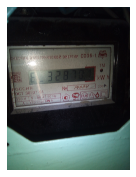

In [ ]:
results.show_and_predict_image()

In [ ]:
garbage_list = []

In [ ]:
results.check(r_list=garbage_list)


['0000cf04d4--5ee7c9d79a7abf239a1306ba_4b8949e5d13c88c9fc3de83e87b7c916_JPEG_20200615_231954.jpg', '0000cf04d4--5ee7dba86f6bd626c02fb242_b6686da3e1e982605d71b1440191d26d_JPEG_20200616_013622.jpg', '0000cf04d4--5eef9932c847423e9e5c1cec_c9e09bb3e7bd2ba6f76d7573c489199f_JPEG_20200622_013029.jpg', '0000cf04d4--5ee8871f6f6bd626c033208c_de8f66d9a7b8624df7f2ad8072d5e07c_JPEG_20200616_114731.jpg', '0000cf04d4--5eea107fea9b1321c20c777a_8474efeccc88ea7cb7bc6a447d42a238_JPEG_20200617_174424.jpg', '0000cf04d4--5ee758dafae71e42d8c147f0_4ee4281b92ca444592416880c353adc0_JPEG_20200615_141800.jpg', '0000cf04d4--5eedd6debca8537642c6ec95_3d9f65c0751540187863e4a8dec9415d_JPEG_20200620_122940.jpg', '0000cf04d4--5ee8c8928e47345b93f61c65_55b5a1148ac252ec98661c4abd1bdd3e_JPEG_20200616_162446.jpg', '0000cf04d4--5ee783cad1042e13cb81be4d_5985a320eb695af032aeb7d3999cd7bd_JPEG_20200615_172100.jpg', '0000cf04d4--5ee895d648e90357968d5b6a_530e67a64ead7831134e714420c632e7_JPEG_20200616_125018.jpg', '0000cf04d4--5eec3

In [ ]:
# checks.check_duplicates()

In [ ]:
duplicates_list_cnn = ['0000c787b8--5ee876e45179207bc904c052_637eb36585de325fdd0bc9fac63809d0_JPEG_20200616_103822.jpg', '0000c787b8--5ee7eb926f6bd626c02ff816_23a6de0053277d55248f9bf9c0d5c4a2_9ECC0268-EBDB-41C8-9527-6BEBABA25A04.jpg', '0000c787b8--5ee7ec4b04f1721ba130afa7_07770115c47c99c8ef71469017484a47_JPEG_20200616_004705.jpg', '0000c787b8--5ee7f4ff1ecd8b053ece3747_d72d9868dd3be43de818719957bb4733_JPEG_20200616_012402.jpg', '0000c787b8--5ee8f29261e8c4651e70d80c_3b60f60996c9f5a7e3f0a88ff60b3fde_JPEG_20200616_232706.jpg', '0000c787b8--5ee8fc2572ac6c1ac5f21a42_229da2487f124b3e40bab252420d97c2_JPEG_20200617_010706.jpg', '0000c787b8--5ee893c7c08d9d736d1fd916_c398e842c197f1804fcb0c4acda32a88_JPEG_20200616_124140.jpg', '0000c787b8--5ee8b8ad72ac6c1ac5efa7d7_d30471fe7d9bc167f02d00c0478b0de9_FD2290C4-0A08-472E-8E82-C9F36FF04A26.jpg', '0000c787b8--5ee857029d0ef365685aaab2_e3a403249d039dc8264a13e5c3e9a05d_EA7CB0B4-DE65-4510-8135-8FD1CA49DC5F.jpg', '0000c787b8--5ee8c0979d0ef365685eddad_82a58b740663a6e8108c9ffa53b75823_JPEG_20200616_155129.jpg', '0000c787b8--5ee8492c90472f3e99fed426_2f32bbd36d7ddd20f21e8a39ba207e23_JPEG_20200616_092311.jpg', '0000c787b8--5ee895cb84887e574238d0d9_6051aa11fef9688563cf87b71cd3b0ae_JPEG_20200616_125011.jpg', '0000c787b8--5ee8d9d5d084283c8a03ff42_01821dd9178d707e2cda36ee692bd2ca_D5AEC7E6-176E-464F-9E65-6C22417CBAC9.jpg', '0000c787b8--5ee8fe5790472f3e9905992a_ee67fd9d11e1cb61cb6afb15baf64ed6_63D5EEE7-8344-4B81-A677-045DED301308.jpg', '0000c787b8--5ee892cd7e1dd26404ebe80d_b336576756825d4e18b6064ba2ffba9f_JPEG_20200616_163720.jpg', '0000c787b8--5ee90ca85179207bc90ae7f7_b83e7514a01225d1b73c8b4dfb2465cf_JPEG_20200616_211717.jpg', '0000c787b8--5ee8f67a90472f3e99054d1a_e42ce3ad523a349e110d20935375675c_C2089C9B-4BB0-4615-95BA-C5483354BCF2.jpg', '0000c787b8--5ee8e6afedadd72d0aa61538_a3ca1732f863129fe3eeb95abede3fa7_JPEG_20200616_203506.jpg', '0000c787b8--5ee88032fa292f4b2ebbce66_223eb4f3ee9a382ee0b26f91e8a391f3_D49CB268-D978-4D54-B1FA-FCDC8FD42C3D.jpg', '0000c787b8--5ee89399966c3433b5e34ccd_a11d96f004bbf8355e440539d12d81cc_JPEG_20200616_123933.jpg', '0000c787b8--5ee834e784887e574235f9fb_2f32bbd36d7ddd20f21e8a39ba207e23_JPEG_20200616_075643.jpg', '0000c787b8--5ee89d6b96eec17639d4017b_5d8a4d039a9060b9fe3bde0872870a9c_05D4198F-6B75-4815-AFC6-7EDDD518DDCA.jpg', '0000c787b8--5ee8fa6996eec17639d7e094_011d78e3ce330da1efc9abe2b4313eab_JPEG_20200616_195958.jpg', '0000c787b8--5ee893c3ac831654d04dc962_0d0114c0e40d33cb78c3cdc82e7078f6_B28F81F2-12B1-4BA8-805F-A41DF9CF0F64.jpg', '0000c787b8--5ee8fb6571ac456ae0c8b1dc_4babf9d7809f0f1b78935fb6adde828f_JPEG_20200616_230335.jpg', '0000c787b8--5ee7fe92a8e2925861d11ce0_6f6cb31db705bdc02fa03c6f804c560d_JPEG_20200616_020458.jpg', '0000c787b8--5ee8330a72ac6c1ac5eb0d40_3fb8c53440981773213d0043a589106f_JPEG_20200616_135056.jpg', '0000c787b8--5ee83abac71ebe56015b5051_42d1a09445320f2214c0804de3561cf8_JPEG_20200616_082209.jpg', '0000c787b8--5ee8af8bd1042e13cb897aef_cf7ce118b0e976afe4745b1ac8d6a74b_6D861C3C-A7C7-431C-B89E-F33BF9CF9DEE.jpg', '0000c787b8--5ee88c2451eb8e792781ed72_97927e042286afbb5c1016bdb5d0bd3c_JPEG_20200616_160854.jpg', '0000c787b8--5ee8c735fa292f4b2ec089d2_82890aa42a7837060b264befee3daea1_JPEG_20200616_162146.jpg', '0000c787b8--5ee7e3ff5fa5cb250aa0c7fb_2f55763f0f7769c40e371779e544039a_JPEG_20200616_011906.jpg', '0000c787b8--5ee8aa2f1ecd8b053ed2a161_e752b3d5edb1fdb365b36558a3a4539e_094E60E8-375A-4594-A608-491FEB17483C.jpg', '0000c787b8--5ee8f773ac831654d051d820_97430ac209de59a429d9c6223ab8c7f0_A56772CC-0B3F-4940-8D18-2D2437373386.jpg', '0000c787b8--5ee89d599d0ef365685d402a_a822eea265b23dc13c696f2615ce6351_JPEG_20200616_132224.jpg', '0000c787b8--5ee8780d48e90357968c1bc0_77f07e82c193037dd634e342072f577e_21CA3DDD-0A95-4EDE-9689-BE9A9D3C83B3.jpg', '0000c787b8--5ee7e5b55179207bc9025d3a_fbc080741c724c6bf226e454fec50bf3_JPEG_20200616_001934.jpg', '0000c787b8--5ee8ec3084887e57423c66bf_448d74fdc24405fefa6d289c6dd64ac0_JPEG_20200616_185851.jpg', '0000c787b8--5ee8d04b72ac6c1ac5f079c5_637eb36585de325fdd0bc9fac63809d0_JPEG_20200616_165946.jpg', '0000c787b8--5ee888f31e017c2f7df4a469_3f4364544ebe6a9a6cef5ab084f10ce5_JPEG_20200616_115518.jpg', '0000c787b8--5ee8c2c4c481e365b5a1f367_c0d7d1012c73aed731425cf773caeddc_CB56BC48-2582-4880-A988-F62DEF5F5A66.jpg', '0000c787b8--5ee89871d1042e13cb886492_62f95571752178b8c9cd44b33793f689_JPEG_20200616_130110.jpg', '0000c787b8--5ee8c9eb7aca363601914b6d_d64251e55255986384b91ebe6111fef3_JPEG_20200616_203146.jpg', '0000c787b8--5ee8870b7aca3636018e62ba_80d4f1383bb85fcc4b53679755a2ffd9_JPEG_20200616_154708.jpg', '0000c787b8--5ee8e981c481e365b5a34bdf_1d113f5c758a187ad32473d9df559155_B2C6ECCB-EC50-4A46-B9FF-A048E7D04480.jpg', '0000c787b8--5ee7c52c9d0ef36568589d09_01b7b8b5e4c1b90d62849a32eceb7756_JPEG_20200615_220033.jpg', '0000c787b8--5ee7c84f71ac456ae0c0456a_b9c6bd914f1ed047c5bfb804294485a4_JPEG_20200616_011334.jpg', '0000c787b8--5ee9083772ac6c1ac5f291d6_a1a548924741b2f6888fda2ad46f4f94_JPEG_20200616_205614.jpg', '0000c787b8--5ee8384051eb8e79277f8cbe_7df84a2e5bae2144e172388ef2cc2a2f_JPEG_20200616_101003.jpg', '0000c787b8--5ee7f4141e017c2f7df1a7f3_d72d9868dd3be43de818719957bb4733_JPEG_20200616_012007.jpg', '0000c787b8--5ee84dca72ac6c1ac5eb72b4_0f9d665ada6ff24f03585ea975d2af88_JPEG_20200616_074254.jpg', '0000c787b8--5ee893a7fae71e42d8c938a6_38ceeca3f74cba0023bbabab3c571a31_JPEG_20200616_164836.jpg', '0000c787b8--5ee7e8299a7abf239a139f16_bf8e3a948f5d3ddf8ce138c58a3b3873_JPEG_20200616_002914.jpg', '0000c787b8--5ee8ce9461e8c4651e6f910a_6ed016faf69b3cee38c5c95ccc589829_JPEG_20200616_184938.jpg', '0000c787b8--5ee85ba804f1721ba13215ec_323f25f7d26ca6c404aff3a593ee7e36_153D1802-6651-4577-851C-FD66F0CBFC01.jpg', '0000c787b8--5ee9009eea9b1321c205a2db_1f9d7c35220eade29066637d817fd0db_4993B084-B256-48D4-84B2-D7C65C27DB7B.jpg', '0000c787b8--5ee8b33b9a7abf239a18a878_4c061913f20719a96986dc8ae20dfb22_JPEG_20200616_215544.jpg', '0000c787b8--5ee7cb9e84887e574234964a_892a23db90482f08196c957fa5e7e621_JPEG_20200616_002846.jpg', '0000c787b8--5ee8769ac481e365b59e6f46_fffcc3c981f433871967cca06d673e9e_JPEG_20200616_143529.jpg', '0000c787b8--5ee87ca872ac6c1ac5ece1e4_0c8e9779bd60bcceab888df7c169c56c_9891420A-98B6-4162-B4A6-17A4AB798EFF.jpg', '0000c787b8--5ee9070248e903579691f1f9_4cbfe60f96cc1803b9352fc4a5e7de0c_JPEG_20200616_225427.jpg', '0000c787b8--5ee8b03bc71ebe56015f6cf3_ec10b8e51e277e4292b2114dbfbd0c5f_JPEG_20200616_144406.jpg']


In [ ]:
checks.send_from_here(garbage_list)

In [ ]:
garbage_list = []
with open("/content/garbage_list.txt", "r") as f:
  garbage_list = f.read()

len([i for i in garbage_list])
garbage_list=garbage_list.replace("[","")
garbage_list=garbage_list.replace("]","")
garbage_list=garbage_list.replace("\n","")
garbage_list=garbage_list.replace("'","")
garbage_list = list(garbage_list.split(", ")) 
len(garbage_list)
garbage_list
   

In [ ]:
checks.send_from_here(garbage_list)

In [ ]:
TolokaHandleResults.send_rejected()

In [ ]:
#Delete rejected images
GARBAGE_LIST =duplicates_list_cnn
# os.chdir(IMAGE_DIR_ALL)
for i in GARBAGE_LIST:
   try:
      os.remove(f'{IMAGE_DIR_ALL}/{i}')
   except FileNotFoundError:
      print("Wrong file or file path")

dir_len = len([name for name in os.listdir('.')])
print(dir_len)
# os.chdir('/content')
print('-------------------------------')
print('it was',f'{len(GARBAGE_LIST) + dir_len}', 'in the beginning')

6518
6580
-------------------------------
it was 6518 in the beginning


In [ ]:
!wget https://storage.googleapis.com/toloka-main/m_tarif/ALL/ALL_ACCEPTED_m_tarif_29-06-2020_06-34-38_AM.zip

--2020-07-03 03:00:10--  https://storage.googleapis.com/toloka-main/m_tarif/ALL/ALL_ACCEPTED_m_tarif_29-06-2020_06-34-38_AM.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8480532343 (7.9G) [application/zip]
Saving to: ‘ALL_ACCEPTED_m_tarif_29-06-2020_06-34-38_AM.zip’

ALL_ACCEPTED_m_tari 100%[===================>]   7.90G  36.6MB/s    in 3m 1s   

2020-07-03 03:03:11 (44.6 MB/s) - ‘ALL_ACCEPTED_m_tarif_29-06-2020_06-34-38_AM.zip’ saved [8480532343/8480532343]



In [ ]:
!unzip /content/ALL_ACCEPTED_m_tarif_29-06-2020_06-34-38_AM.zip -d /content

Archive:  /content/ALL_ACCEPTED_m_tarif_29-06-2020_06-34-38_AM.zip
   creating: /content/content/ALL_ACCEPTED_m_tarif_29-06-2020_06-34-38_AM/
  inflating: /content/content/ALL_ACCEPTED_m_tarif_29-06-2020_06-34-38_AM/0000cf04d4--5edf8104ae1ac93a85dcc5a6_b039cf6c6f129b6c22415308a4710a10_2266A59E-FEEC-4FA8-B2A9-DC578795F85C.jpg  
  inflating: /content/content/ALL_ACCEPTED_m_tarif_29-06-2020_06-34-38_AM/0000cf04d4--5ec3dc032f29c328590c2ecb_68d8f9d8ec6e588c33b0e02e9f6bb37a_JPEG_20200519_161623.jpg  
  inflating: /content/content/ALL_ACCEPTED_m_tarif_29-06-2020_06-34-38_AM/0000cf04d4--5ec3c64cd96ee5669f81a199_501cd72e581ec845fc19337e16f4c6af_9810926A-E218-4D46-9C75-344780B39901.jpg  
  inflating: /content/content/ALL_ACCEPTED_m_tarif_29-06-2020_06-34-38_AM/0000cf04d4--5ee7ee0d7aca3636018b7a60_14fce6b02c24c00441a0e4dedf5d0cbd_JPEG_20200616_005550.jpg  
  inflating: /content/content/ALL_ACCEPTED_m_tarif_29-06-2020_06-34-38_AM/0000cf04d4--5eeae46521a9913300371a1e_38aff46c3c74080dbac999028e34e24

In [ ]:
checks.load_model()

Copying gs://toloka-main/models/export_presense_classif003.pkl...
| [1/1 files][ 41.8 MiB/ 41.8 MiB] 100% Done                                    
Operation completed over 1 objects/41.8 MiB.                                     


no_present_meters
1


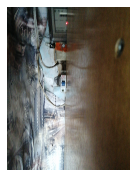

In [ ]:
checks.show_and_predict_image()

In [ ]:
checks = TolokaFilterResults()


Status of photos.Select SUBMITTED/REJECTED/ACCEPTED. Default SUBMITTED: 
Project short name. Select m_tarif/o_tarif. Default o_tarif: 
Set limit number of photos to download. Default 10000: 
Set pool id: 13567188 multi, 13076408 one 


In [ ]:
checks.check(duplicates_list_cnn)


['0000c787b8--5ee471941e017c2f7ddcc88f_eae113ae05fc928a340fd9162aed7bc7_JPEG_20200613_112655.jpg', '0000c787b8--5ee61cd67e1dd26404dd7211_fe9eeeee8c835b33902601b32f30d717_JPEG_20200614_164845.jpg', '0000c787b8--5ee4d1c55fa5cb250a8ee76a_48a8f8e001c26e5a80b1226d1ad28497_JPEG_20200613_161656.jpg', '0000c787b8--5ee4b09504f1721ba11d750d_d291340e23acc42f54cf0ddb50256ddb_JPEG_20200613_155604.jpg', '0000c787b8--5ee34be8edadd72d0a848ddc_faf4c70e6f157b1a842aad931b3d2cc7_JPEG_20200612_123334.jpg', '0000c787b8--5ee612681e017c2f7de61299_afa829ed597edca945a671f200e78821_JPEG_20200614_150528.jpg', '0000c787b8--5ee7c576ea9b1321c2fcf1ba_afd899f284b92e73cefcea0b0e5d294b_JPEG_20200615_220118.jpg', '0000c787b8--5ee33f959d0ef365683e3900_31f875c04c04ba509727261985ebab7d_JPEG_20200612_134104.jpg', '0000c787b8--5ee90cf3d084283c8a05e38a_9fc4aeff05cc80849e4f7ea8e2481d9b_AA8F73EF-106D-4BA2-8C29-44562A918CD3.jpg', '0000c787b8--5ee4edf151eb8e79276dbef5_2644f831cd946e8b19d9e878fbc834fb_JPEG_20200613_201752.jpg', '0

# II and III check

In [ ]:
settings.path_to_save_photos = '/content/content/ALL_ACCEPTED_m_tarif_29-06-2020_06-34-38_AM'

Copying gs://toloka-main/models/export_multione003.pkl...
- [1/1 files][ 41.8 MiB/ 41.8 MiB] 100% Done                                    
Operation completed over 1 objects/41.8 MiB.                                     
multi
0


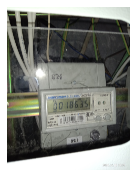

In [ ]:
#multi_or_one
# results.load_model(what_task='presense')
results.load_model(what_task='multi_or_one')
results.show_and_predict_image()


In [ ]:
results.check(r_list=[])


['0000cf04d4--5ee8b564c71ebe56015fb92b_0d0114c0e40d33cb78c3cdc82e7078f6_A7D64C96-0645-4D3F-84F3-2BED3BADD92E.jpg', '0000cf04d4--5eccc19acd2d2c568c74e9e2_e0499d4077aa8447ccf895b707e00b10_JPEG_20200526_121333.jpg', '0000cf04d4--5ef1e7b83367bf1a0a0b42a1_9a2f0d8ce98cc88b94b82fbbe5b0a78c_JPEG_20200623_143002.jpg', '0000cf04d4--5eca90940e3bd126183bdfcf_2d6250fbc3ec08dd2c497e98c88cb501_JPEG_20200524_201842.jpg', '0000cf04d4--5ee9ece21e017c2f7dfed050_5202224aa762ac40f04f4bb79f434d1d_JPEG_20200617_131358.jpg', '0000cf04d4--5eebacb8e4461666c6b6167b_123fb08c31fe0957e52b39bcab64df9c_9B755C5C-442F-4B5C-B9EE-49143E1462DE.jpg', '0000cf04d4--5ee9dda861e8c4651e7622dc_70fcd8b275d33736a05b5c1d92ae9a2c_8AD03D6D-8FBC-4A2B-BF9A-DF0B0BAB6D81.jpg', '0000cf04d4--5eec54eb08128e771740f75c_d79361a60236cc5cff8ca4ed4a2bf43b_JPEG_20200619_090222.jpg', '0000cf04d4--5ec78ebd391fb546e0977060_b0015d2de2ddca6e2a59f9c0662d4fce_8D07F6C9-BAE6-45C4-8852-8B3C09770C81.jpg', '0000cf04d4--5ec4be5f7c474278817e477c_6828c0c35f4017

In [ ]:
one_tarif_garbage = pd.read_csv("/content/o_tarif.csv")
one_tarif_garbage = one_tarif_garbage['o_tarif']

In [ ]:
#/content/m_tarif.csv
garbage = pd.read_csv("/content/m_tarif.csv")
garbage = garbage['m_tarif']


for i in garbage:
  # print(type(i))
  i=i.replace("[","")
  i=i.replace("]","")
  i=i.replace("\n","")
  i=i.replace("'","")
  li = list(i.split(", ")) 
  # li = list(i.split(' '))
li


['0000cf04d4--5edf8104ae1ac93a85dcc5a6_b039cf6c6f129b6c22415308a4710a10_2266A59E-FEEC-4FA8-B2A9-DC578795F85C.jpg',
 '0000cf04d4--5ec3dc032f29c328590c2ecb_68d8f9d8ec6e588c33b0e02e9f6bb37a_JPEG_20200519_161623.jpg',
 '0000cf04d4--5ec3c64cd96ee5669f81a199_501cd72e581ec845fc19337e16f4c6af_9810926A-E218-4D46-9C75-344780B39901.jpg',
 '0000cf04d4--5ee7ee0d7aca3636018b7a60_14fce6b02c24c00441a0e4dedf5d0cbd_JPEG_20200616_005550.jpg',
 '0000cf04d4--5eeae46521a9913300371a1e_38aff46c3c74080dbac999028e34e241_JPEG_20200618_125002.jpg',
 '0000cf04d4--5ec67246f90e1f560559905b_ab6a7d4ca4d65f3c7edc2cd4fe0bc54a_JPEG_20200521_162215.jpg',
 '0000cf04d4--5edf7085d3f2e96a05b02afe_f3795cfffe030b111596baf35ae4232b_JPEG_20200609_162039.jpg',
 '0000cf04d4--5edf76a155b06430ac88caab_96e0379cc5b8163cd42b2826ed36fe22_JPEG_20200609_184647.jpg',
 '0000cf04d4--5eeb8573b7d684186eec7a6a_becd213c6d20a48e5b8b37b3c6c08310_JPEG_20200618_181720.jpg',
 '0000cf04d4--5ec95b66dc501f78a6c65a72_f8389c36f59bda0cec0eebacbe81517c_JPEG_

In [ ]:
garbage = li

In [ ]:
len(garbage)

2844

In [ ]:
len(garbage_list1)

In [ ]:
# exclude_list = one_tarif_garbage1 + garbage_list1
exclude_list = one_tarif_garbage1 

In [ ]:
len(exclude_list)

255

In [ ]:
results.remove_rejected_from_dir(exclude_list)

2844
-------------------------------
it was 3099 in the beginning


In [ ]:
!zip -r /content/ALL_ACCEPTED_m_tarif_29-06-2020_06-34-38_AM.zip /content/ALL_ACCEPTED_m_tarif_29-06-2020_06-34-38_AM

  adding: content/ALL_ACCEPTED_m_tarif_29-06-2020_06-34-38_AM/ (stored 0%)
  adding: content/ALL_ACCEPTED_m_tarif_29-06-2020_06-34-38_AM/0000cf04d4--5edf8104ae1ac93a85dcc5a6_b039cf6c6f129b6c22415308a4710a10_2266A59E-FEEC-4FA8-B2A9-DC578795F85C.jpg (deflated 1%)
  adding: content/ALL_ACCEPTED_m_tarif_29-06-2020_06-34-38_AM/0000cf04d4--5ec3dc032f29c328590c2ecb_68d8f9d8ec6e588c33b0e02e9f6bb37a_JPEG_20200519_161623.jpg (deflated 0%)
  adding: content/ALL_ACCEPTED_m_tarif_29-06-2020_06-34-38_AM/0000cf04d4--5ec3c64cd96ee5669f81a199_501cd72e581ec845fc19337e16f4c6af_9810926A-E218-4D46-9C75-344780B39901.jpg (deflated 0%)
  adding: content/ALL_ACCEPTED_m_tarif_29-06-2020_06-34-38_AM/0000cf04d4--5ee7ee0d7aca3636018b7a60_14fce6b02c24c00441a0e4dedf5d0cbd_JPEG_20200616_005550.jpg (deflated 0%)
  adding: content/ALL_ACCEPTED_m_tarif_29-06-2020_06-34-38_AM/0000cf04d4--5eeae46521a9913300371a1e_38aff46c3c74080dbac999028e34e241_JPEG_20200618_125002.jpg (deflated 1%)
  adding: content/ALL_ACCEPTED_m_tarif

In [ ]:
!gcloud init

Welcome! This command will take you through the configuration of gcloud.

Settings from your current configuration [default] are:
component_manager:
  disable_update_check: 'True'
compute:
  gce_metadata_read_timeout_sec: '0'

Pick configuration to use:
 [1] Re-initialize this configuration [default] with new settings 
 [2] Create a new configuration
Please enter your numeric choice:  1

Your current configuration has been set to: [default]

You can skip diagnostics next time by using the following flag:
  gcloud init --skip-diagnostics

Network diagnostic detects and fixes local network connection issues.
Reachability Check passed.
Network diagnostic passed (1/1 checks passed).

You must log in to continue. Would you like to log in (Y/n)?  y

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuser

In [ ]:
 !gsutil -m cp -r /content/ALL_ACCEPTED_m_tarif_29-06-2020_06-34-38_AM.zip gs://toloka-main/m_tarif/ALL/ALL_ACCEPTED_m_tarif_29-06-2020_06-34-38_AM.zip

Copying file:///content/ALL_ACCEPTED_m_tarif_29-06-2020_06-34-38_AM.zip [Content-Type=application/zip]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

-
Operation completed over 1 objects/7.9 GiB.                                      


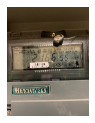

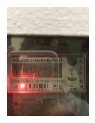

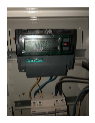

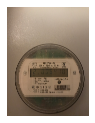

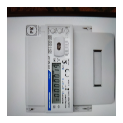

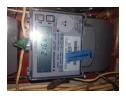

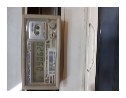

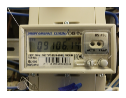

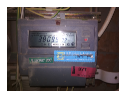

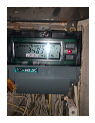

In [ ]:
# import random
for img in one_tarif_garbage1[30:40]:
  img = open_image(f'{settings.path_to_save_photos}/{img}')
  img.show(figsize=(2,2))


In [ ]:
results.send_from_here(r_list=one_tarif_garbage1)

Streaming output truncated to the last 5000 lines.

    {
                "status": "REJECTED",
                "public_comment": "Не соответствует требованиям инструкции"
            }
    
b'{"id":"0000cf04d4--5ee8934a04f1721ba1342c78","task_suite_id":"0000cf04d4--5ed4f5e70d57ee6e10879664","pool_id":"13567188","user_id":"79dfe3ec758ec0b1a078b749d814e1be","status":"REJECTED","reward":0.02,"tasks":[{"id":"5bae8fbc-7918-4e70-97bd-c6780f3eda81","input_values":{"id":1}}],"solutions":[{"output_values":{"image":"ca669cc6-693e-4f26-a774-b46e1c63d055"}}],"public_comment":"\xd0\x9d\xd0\xb5 \xd1\x81\xd0\xbe\xd0\xbe\xd1\x82\xd0\xb2\xd0\xb5\xd1\x82\xd1\x81\xd1\x82\xd0\xb2\xd1\x83\xd0\xb5\xd1\x82 \xd1\x82\xd1\x80\xd0\xb5\xd0\xb1\xd0\xbe\xd0\xb2\xd0\xb0\xd0\xbd\xd0\xb8\xd1\x8f\xd0\xbc \xd0\xb8\xd0\xbd\xd1\x81\xd1\x82\xd1\x80\xd1\x83\xd0\xba\xd1\x86\xd0\xb8\xd0\xb8","mixed":false,"automerged":false,"created":"2020-06-16T09:39:22.308","submitted":"2020-06-16T09:39:44.175","rejected":"2020-06-24T20:56

In [ ]:
#TODO check multi or one 

In [ ]:
checks.remove(garbage_list)


# Types classifier

In [ ]:
!wget https://storage.googleapis.com/toloka-main/o_tarif/ALL_EDITED_ACCEPTED_o_tarif_24-06-2020_06-59-53_AM.zip

--2020-07-10 03:49:47--  https://storage.googleapis.com/toloka-main/o_tarif/ALL_EDITED_ACCEPTED_o_tarif_24-06-2020_06-59-53_AM.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 64.233.187.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18195033528 (17G) [application/zip]
Saving to: ‘ALL_EDITED_ACCEPTED_o_tarif_24-06-2020_06-59-53_AM.zip’

ALL_EDITED_ACCEPTED 100%[===================>]  16.95G  41.7MB/s    in 7m 3s   

2020-07-10 03:56:51 (41.0 MB/s) - ‘ALL_EDITED_ACCEPTED_o_tarif_24-06-2020_06-59-53_AM.zip’ saved [18195033528/18195033528]



In [ ]:
!unzip -qq /content/ALL_EDITED_ACCEPTED_o_tarif_24-06-2020_06-59-53_AM.zip -d /content/

In [ ]:
!wget https://storage.googleapis.com/energy_meters_dataset/models/tuned-energy-classificaion-fastai.pkl 

--2020-07-10 04:05:36--  https://storage.googleapis.com/energy_meters_dataset/models/tuned-energy-classificaion-fastai.pkl
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102831043 (98M) [application/octet-stream]
Saving to: ‘tuned-energy-classificaion-fastai.pkl’

tuned-energy-classi 100%[===================>]  98.07M  25.8MB/s    in 3.8s    

2020-07-10 04:05:41 (25.8 MB/s) - ‘tuned-energy-classificaion-fastai.pkl’ saved [102831043/102831043]



In [ ]:
from tqdm.notebook import tqdm
import os
import random
# from imagededup.methods import CNN
from fastai import *
from fastai.vision import *
import warnings
warnings.filterwarnings("ignore")
defaults.device = torch.device('cuda')

In [ ]:
#model name should be export.pkl
learn = load_learner('/content/').to_fp16()

In [ ]:
IMAGE_DIR_ALL = "/content/content/ALL_EDITED_ACCEPTED_o_tarif_24-06-2020_06-59-53_AM"

Energomera CE101
1


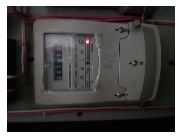

In [ ]:
img= random.choice(os.listdir(IMAGE_DIR_ALL))
img = open_image(f'{IMAGE_DIR_ALL}/{img}')
img.show()
listi = []
learn = learn
pred_class,pred_idx,outputs = learn.predict(img)
print(pred_class)
print(pred_class.data.tolist())



In [ ]:
# learn = load_learner('/content/').to_fp16() 
DATA = IMAGE_DIR_ALL

multi_tarif_list = []
Energomera_CE101 = []
other_5 = []
Mercury201_2 = []
EKF_0 = []
NEVA_4 =[]
Mercury201_7_3 = []


df_tarif_list = pd.DataFrame({'Energomera CE101': []})
df_m_tarif_list = pd.DataFrame({'m_tarif': []})

SKIP_LIST = []

# learn = load_learner('/content', 'export.pkl', test = SegmentationItemList.from_folder(DATA), tfm_y=False).to_fp16()
# preds = learn.get_preds(ds_type=DatasetType.Test)

for img in tqdm(os.listdir(DATA)):
  try:
    if img not in SKIP_LIST:  
      img_pred = open_image(os.path.join(DATA,img))
      pred_class,pred_idx,outputs = learn.predict(img_pred)
      preds = pred_class.data.tolist()

      if preds == 1:  
        Energomera_CE101.append(img)
      elif preds ==2:
        Mercury201_2.append(img)
      elif preds == 3 :
        Mercury201_7_3.append(img)
      elif preds == 4:
        NEVA_4.append(img)
      elif preds == 0:
        EKF_0.append(img)
      else:
        other_5.append(img)
      
  except IOError:
      continue


In [ ]:
print('Energomera_CE101 ', len([e for e in Energomera_CE101]))
print('Mercury201_2 ',len([e for e in Mercury201_2]))
print('Mercury201_7_3 ',len([e for e in Mercury201_7_3]))
print('NEVA_4 ',len([e for e in NEVA_4]))
print('EKF_0 ',len([e for e in EKF_0]))
print('other_5 ',len([e for e in other_5]))


Energomera_CE101  1828
Mercury201_2  837
Mercury201_7_3  294
NEVA_4  627
EKF_0  317
other_5  2254


In [ ]:
import pandas as pd

In [ ]:
df_tarif_list.to_csv("Energomera_CE101.csv", index=False)

In [ ]:
# Energomera_CE101  2+1846
# Mercury201_2  837
# Mercury201_7_3  294
# NEVA_4  627
# EKF_0  317
# other_5  2254

In [ ]:
pd.DataFrame(Energomera_CE101, columns =["Energomera_CE101"]).to_csv("Energomera_CE101.csv", index=False)

In [ ]:
pd.DataFrame(Mercury201_2, columns =["Mercury201"]).to_csv("Mercury201.csv", index=False)
pd.DataFrame(Mercury201_7_3, columns =["Mercury201_7"]).to_csv("Mercury201_7.csv", index=False)
pd.DataFrame(NEVA_4, columns =["NEVA"]).to_csv("NEVA.csv", index=False)
pd.DataFrame(EKF_0, columns =["EKF"]).to_csv("EKF.csv", index=False)
pd.DataFrame(other_5, columns =["other"]).to_csv("other.csv", index=False)

In [ ]:
#/content/m_tarif.csv
Energomera_CE101 = pd.read_csv("/content/Energomera_CE101.csv")
Energomera_CE101 = Energomera_CE101['Energomera_CE101']


for i in Energomera_CE101:
  # print(type(i))
  i=i.replace("[","")
  i=i.replace("]","")
  i=i.replace("\n","")
  i=i.replace("'","")
  li = list(i.split(", ")) 
  # li = list(i.split(' '))
print(len(li))
# li


1828


In [ ]:
Mercury201 = pd.read_csv("/content/Mercury201.csv")

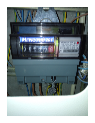

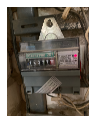

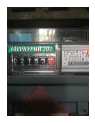

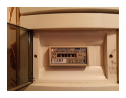

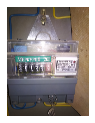

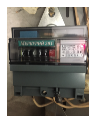

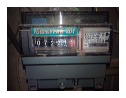

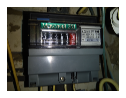

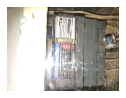

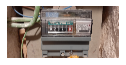

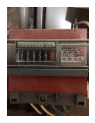

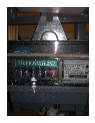

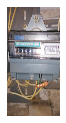

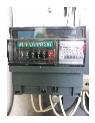

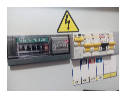

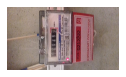

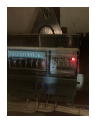

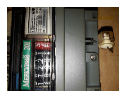

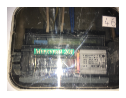

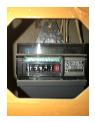

In [ ]:
def look_at_results(li):
  for img in li[10:30]:
    img = open_image(f'{IMAGE_DIR_ALL}/{img}')
    img.show(figsize=(2,2))
look_at_results(Mercury201['Mercury201'])

In [ ]:
!mkdir mercury201

In [ ]:
import shutil
li = Mercury201['Mercury201']
for img in li:
  try:
    shutil.move(src=(f'{IMAGE_DIR_ALL}/{img}'),dst='/content/mercury201')
  except:  
    pass
# print(len([e for e in os.listdir("/content/energomera_CE101")]))

In [ ]:
!zip -r /content/mercury201.zip /content/mercury201

 (deflated 2%)
  adding: content/mercury201/0000c787b8--5ee0c76f98f49f0effd6b3d7_b39c5c93853a692ea28633d24a4d04fa_JPEG_20200610_144347.jpg (deflated 0%)
  adding: content/mercury201/0000c787b8--5ed80c0e845a1c26f66963ce_d63a0ebcd025bba1fd81714682b89679_89CCECE7-690A-474F-A428-AFE21F710958.jpg (deflated 0%)
  adding: content/mercury201/0000c787b8--5ece700edbdd473c69a8dc90_fd754bd873cd9e2677e9d1190fe4af10_JPEG_20200527_205023.jpg (deflated 0%)
  adding: content/mercury201/0000c787b8--5ed78f6fc9fc2c52f15b8674_e1f72fe9882f2325b8d13c6fa11df4fe_JPEG_20200603_185437.jpg (deflated 1%)
  adding: content/mercury201/0000c787b8--5ee0c67b3c0100187b09915f_b39c5c93853a692ea28633d24a4d04fa_JPEG_20200610_143949.jpg (deflated 0%)
  adding: content/mercury201/0000c787b8--5ee8b92361e8c4651e6ed265_4c12cca71c249d383ead978d80bcc1de_JPEG_20200616_152103.jpg (deflated 1%)
  adding: content/mercury201/0000c787b8--5ee5f7193656fb65f4d92436_d8091bc3627bc19d5a5d614b9c04b359_JPEG_20200614_151135.jpg (deflated 0%)
  a

In [ ]:
!gcloud init

In [ ]:
# print(len([e for e in os.listdir("/content/energomera_CE101")]))

In [ ]:
!ls /content/energomera_CE101_rotated

In [ ]:
import cv2

In [ ]:
img_path = "/content/energomera_CE101"
img_path_new = "/content/energomera_CE101_rotated"

In [ ]:
def rotate_with_cv2(img):
  image = cv2.imread(os.path.join(img_path,img))
  cv2.imwrite(os.path.join(img_path_new,img),image)

for img in os.listdir(img_path):
  rotate_with_cv2(img)


In [ ]:
!zip -r /content/energomera_CE101_rotated.zip /content/energomera_CE101_rotated

In [ ]:
!gcloud init

In [ ]:
!gsutil -m cp /content/mercury201.zip  gs://toloka-main/o_tarif/enmet_models  

Copying file:///content/mercury201.zip [Content-Type=application/zip]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/
Operation completed over 1 objects/2.2 GiB.                                      


# Project manager

In [ ]:
#toloka_api.py 

import requests
import time
import pandas as pd


class TolokaProcessingApi:
    def __init__(self, toloka_token):
        self.toloka_token = toloka_token
        self.headers = headers = {"Authorization": "OAuth " + toloka_token}

    def create_toloka_project(self, project_params):
        req = requests.post("https://toloka.yandex.ru/api/v1/projects", headers=self.headers, json=project_params)
        assert (req.ok)
        new_project_id = req.json()['id']
        print("New project was created. New project id: ", new_project_id)
        print("https://toloka.yandex.ru/requester/project/{}".format(new_project_id))
        return new_project_id

    def create_toloka_pool(self, project_id, pool_params):
        pool_params['project_id'] = str(project_id)
        req = requests.post("https://toloka.yandex.ru/api/v1/pools", headers=self.headers, json=pool_params)
        assert (req.ok)
        new_pool_id = req.json()['id']
        print("New pool was created. New pool id: ", new_pool_id)
        return new_pool_id

    def clone_toloka_pool(self, pool_id):
        req = requests.post("https://toloka.yandex.ru/api/v1/pools/{}/clone".format(pool_id), headers=self.headers)
        assert (req.ok)
        operation_id = req.json()['id']
        time.sleep(10)
        operation_status = requests.get("https://toloka.yandex.ru/api/v1/operations/{}".format(operation_id),
                                        headers=self.headers).json()

        assert (operation_status['status'] == 'SUCCESS')

        new_pool_id = operation_status['details']['pool_id']
        print("Pool was cloned. New pool was created. New pool id: ", new_pool_id)
        print("https://toloka.yandex.ru/requester/pool/{}".format(new_pool_id))
        return new_pool_id

    def upload_toloka_tasks(self, tasks):
        req = requests.post("https://toloka.yandex.ru/api/v1/task-suites?allow_defaults=true",
                            headers=self.headers, json=tasks)
        if not req.ok:
            print(req.text)
        assert (req.ok)

    def run_toloka_pool(self, pool_id):
        req = requests.post("https://toloka.yandex.ru/api/v1/pools/{}/open".format(pool_id), headers=self.headers)
        assert (req.ok)
        print("Pool {} was started".format(pool_id))

    def print_toloka_pool_link(self, pool_id):
        print("https://toloka.yandex.ru/requester/pool/{}".format(pool_id))

  
    def get_pool_completed_tasks(self, pool_id):
        req = requests.get("https://toloka.yandex.ru/api/v1/assignments?pool_id={}&limit=10000".format(pool_id),
                           headers=self.headers)
        # completed_items = req.json()["items"]
        completed_items = req.json()["items"]
        # return completed_items
        all_tasks = []
        all_solutions = []
        all_users = []
        for i in completed_items:
            if i.get('solutions') is not None:
                tasks = i.get('tasks', [[]])
                tasks = list(map(lambda x: x['input_values'], tasks))
                all_tasks += tasks

                users = i.get('user_id', '')
                users = list(map(lambda x: x, users))
                all_users += users


                task_solutions = i.get('solutions', [[]])
                task_solutions = list(map(lambda x: x.get("output_values", [[]]), task_solutions))
                all_solutions += task_solutions

        
        df = pd.merge(pd.DataFrame(all_tasks), pd.DataFrame(all_solutions), left_index=True, right_index=True)
        df = pd.merge(df, pd.DataFrame(all_users), left_index=True, right_index=True)

        return df
      

    def get_result_pool_params(self, pool_id):
        req = requests.get("https://toloka.yandex.ru/api/v1/assignments?pool_id={}&limit=10000".format(pool_id), headers=self.headers)
        assert req.ok
        return req.json()

    def get_pool_params(self, pool_id):
        req = requests.get("https://toloka.yandex.ru//api/v1/pools/{}".format(pool_id), headers=self.headers)
        assert req.ok
        return req.json()

    
    def update_result_pool_params(self, pool_id, pool_params):
        # req = requests.put("https://toloka.yandex.ru/api/v1/assignments?pool_id={}&limit=10000".format(pool_id), headers=self.headers,
        #                    json=pool_params)
        req = requests.patch("https://toloka.yandex.ru/api/v1/assignments?pool_id={}&limit=10000".format(pool_id), headers=self.headers,
                           data=pool_params)
        assert req.ok


# exif rotate

In [ ]:
path = img_path
path_to_save = img_path_new

In [ ]:
import PIL.Image
import PIL.ImageOps
import numpy as np
import os
# path = "/content/good_to_accept_part1_200_exif/"
# path_to_save = "/content/good_to_accept_part1_200_exif_converted/"


def exif_transpose(img):
    if not img:
        return img

    exif_orientation_tag = 274

    # Check for EXIF data (only present on some files)
    if hasattr(img, "_getexif") and isinstance(img._getexif(), dict) and exif_orientation_tag in img._getexif():
        exif_data = img._getexif()
        orientation = exif_data[exif_orientation_tag]

        # Handle EXIF Orientation
        if orientation == 1:
            # Normal image - nothing to do!
            pass
        elif orientation == 2:
            # Mirrored left to right
            img = img.transpose(PIL.Image.FLIP_LEFT_RIGHT)
        elif orientation == 3:
            # Rotated 180 degrees
            img = img.rotate(180)
        elif orientation == 4:
            # Mirrored top to bottom
            img = img.rotate(180).transpose(PIL.Image.FLIP_LEFT_RIGHT)
        elif orientation == 5:
            # Mirrored along top-left diagonal
            img = img.rotate(-90, expand=True).transpose(PIL.Image.FLIP_LEFT_RIGHT)
        elif orientation == 6:
            # Rotated 90 degrees
            img = img.rotate(-90, expand=True)
        elif orientation == 7:
            # Mirrored along top-right diagonal
            img = img.rotate(90, expand=True).transpose(PIL.Image.FLIP_LEFT_RIGHT)
        elif orientation == 8:
            # Rotated 270 degrees
            img = img.rotate(90, expand=True)

    return img


def load_image_file(file, mode='RGB'):
    # Load the image with PIL
    img = PIL.Image.open(file)

    if hasattr(PIL.ImageOps, 'exif_transpose'):
        # Very recent versions of PIL can do exit transpose internally
        img = PIL.ImageOps.exif_transpose(img)
    else:
        # Otherwise, do the exif transpose ourselves
        img = exif_transpose(img)

    img = img.convert(mode)
    img.save(os.path.join(path_to_save,file))

    # return np.array(img)


In [ ]:
excepts_list = []
for img in os.listdir(path):
  try:
    load_image_file(os.path.join(path,img))
  except:
    excepts_list.append(img)



/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 282 had too many entries: 2, expected 1
  % (tag, len(values))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 283 had too many entries: 2, expected 1
  % (tag, len(values))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 34853 had too many entries: 0, expected 1
  % (tag, len(values))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 34853 had too many entries: 9, expected 1
  % (tag, len(values))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 34853 had too many entries: 4, expected 1
  % (tag, len(values))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 34853 had too many entries: 6, expected 1
  % (tag, len(values))
/u

In [ ]:
len([e for e in excepts_list])

46

In [ ]:
!zip -r -qq /content/energomera_CE101_exif.zip /content/energomera_CE101

In [ ]:
for img in os.listdir(AL)

In [ ]:
!pip install image_to_numpy

In [ ]:
!pip install Image

In [ ]:
path_src = "/content/energomera_CE101"
path_dst = "/content/energomera_CE101_1826"


In [ ]:
import image_to_numpy
from PIL import Image as Img

In [ ]:
#ROTATE
for img in os.listdir(path_src):
  # try:
    img = image_to_numpy.load_image_file(f'{path_src}/{img}')
    im = Img.fromarray(img)
    im.save(f'{path_dst}/{img}')
    # c = c+1
  # except:
  #   pass
                                      

ValueError: ignored

In [ ]:
path = "/content/energomera_CE101_1826"

In [ ]:
import PIL.Image
import PIL.ImageOps
import numpy as np


def exif_transpose(img):
    if not img:
        return img

    exif_orientation_tag = 274

    # Check for EXIF data (only present on some files)
    if hasattr(img, "_getexif") and isinstance(img._getexif(), dict) and exif_orientation_tag in img._getexif():
        exif_data = img._getexif()
        orientation = exif_data[exif_orientation_tag]

        # Handle EXIF Orientation
        if orientation == 1:
            # Normal image - nothing to do!
            pass
        elif orientation == 2:
            # Mirrored left to right
            img = img.transpose(PIL.Image.FLIP_LEFT_RIGHT)
        elif orientation == 3:
            # Rotated 180 degrees
            img = img.rotate(180)
        elif orientation == 4:
            # Mirrored top to bottom
            img = img.rotate(180).transpose(PIL.Image.FLIP_LEFT_RIGHT)
        elif orientation == 5:
            # Mirrored along top-left diagonal
            img = img.rotate(-90, expand=True).transpose(PIL.Image.FLIP_LEFT_RIGHT)
        elif orientation == 6:
            # Rotated 90 degrees
            img = img.rotate(-90, expand=True)
        elif orientation == 7:
            # Mirrored along top-right diagonal
            img = img.rotate(90, expand=True).transpose(PIL.Image.FLIP_LEFT_RIGHT)
        elif orientation == 8:
            # Rotated 270 degrees
            img = img.rotate(90, expand=True)

    return img


def load_image_file(file, mode='RGB'):
    # Load the image with PIL
    img = PIL.Image.open(file)

    if hasattr(PIL.ImageOps, 'exif_transpose'):
        # Very recent versions of PIL can do exit transpose internally
        img = PIL.ImageOps.exif_transpose(img)
    else:
        # Otherwise, do the exif transpose ourselves
        img = exif_transpose(img)

    img = img.convert(mode)

    return np.array(img)

In [ ]:

for file in os.listdir(path):
  load_image_file(os.path.join(path,file))

# Types split

In [ ]:
!wget https://storage.googleapis.com/energy_meters_dataset/models/model.pkl

--2020-06-24 07:49:00--  https://storage.googleapis.com/energy_meters_dataset/models/model.pkl
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 2a00:1450:4013:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102828524 (98M) [application/octet-stream]
Saving to: ‘model.pkl’

model.pkl           100%[===================>]  98.06M  85.6MB/s    in 1.1s    

2020-06-24 07:49:02 (85.6 MB/s) - ‘model.pkl’ saved [102828524/102828524]



In [ ]:
df = pd.DataFrame()

In [ ]:
lists = ['a','b','c']


In [ ]:
df.append({'somecolumn':[i for i in lists]},ignore_index=True)

somecolumn
0  [a, b, c]

In [ ]:
 df_tarif_list = df_tarif_list.append({'o_tarif': tarif_list}, ignore_index=True,)   